In [1]:
import h5py
import deepdish as dd
from convergenets.utils import utils
from scripts.visualizations.helpers import load_weights
from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import itertools
import deepdish as dd
from scipy.stats import norm as sp_norm
from sklearn.linear_model import LinearRegression


In [2]:
flags = ["overwrite"]
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"

def create_args_string(kwargs, flags, pre_command="python train.py", subset_keys=None):
    s = f"{pre_command} "
    if subset_keys is not None:
        kwargs = {k:v for k,v in kwargs.items() if k in subset_keys}
    for k, v in kwargs.items():
        s += f"--{k} {v} "
    for f in flags:
        s += f"--{f} "
    return s

In [3]:
def load_cache(experiment="hessian", expid="imagenet_pret_ce", expid_eigenvalues=None, **kwargs):
    if expid_eigenvalues is None:
        expid_eigenvalues = expid
    PT_CACHE_DIR = "/mnt/fs6/jvrsgsty/neural-mechanics"
    traj_cache = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/pos_vel.h5"
    weights = dd.io.load(traj_cache, f"/metrics/position")
    grads = dd.io.load(traj_cache, f"/metrics/velocity")
    spectral_cache = f"{PT_CACHE_DIR}/{experiment}/{expid_eigenvalues}/metrics/spectral.h5"
    eigenvectors = dd.io.load(spectral_cache, f"/eigenvector")
    eigenvalues = dd.io.load(spectral_cache, f"/eigenvalues")
    eigen_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[eigen_idx]
    eigenvectors = eigenvectors[:,eigen_idx]
    assert weights.shape == grads.shape
    assert weights.shape[1] == eigenvectors.shape[0]
    return weights, grads, eigenvectors, eigenvalues
    
def project(weights, grads, eigenvectors,eig_idx = 0): 
    projected_weights = np.array(
        [np.dot(weights[i], eigenvectors[:, eig_idx]) for i in range(weights.shape[0])]
    )
    projected_grads = np.array(
        [np.dot(grads[i], eigenvectors[:, eig_idx]) for i in range(grads.shape[0])]
    )
    return projected_weights, projected_grads


In [4]:
exp_kwargs = {
    "experiment": "nonlinear",
    "expid": "cifar10_fc2_evals",
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "dataset": "cifar10",
    "data-dir": "/mnt/fs6/jvrsgsty/data",
    "model-dir": "/mnt/fs6/jvrsgsty/pretrained_models",
    #"pretrained": True,
    "model": "vgg11",
    "model-class": "tinyimagenet",
    "loss": "mse",
    "optimizer": "custom_sgd",
    "test-batch-size": 256,
    "epochs": 0,
    "save-freq": 1, 
    "save-begin-epoch": 10,
    "eigenvector": True,
    "eigen-batch-size": 128,
    "power-iters": 10,
    "eigen-dims": 15,
    # Sweep ofer these
    "train-batch-size": 256,
    "lr": 0.01,
    "wd": 1e-4,
    "momentum": 0.9,
    "gpu": "8",
}
flags = ["overwrite"]
print(create_args_string(exp_kwargs, flags))

python train.py --experiment nonlinear --expid cifar10_fc2_evals --save-dir /mnt/fs6/jvrsgsty/neural-mechanics --dataset cifar10 --data-dir /mnt/fs6/jvrsgsty/data --model-dir /mnt/fs6/jvrsgsty/pretrained_models --model vgg11 --model-class tinyimagenet --loss mse --optimizer custom_sgd --test-batch-size 256 --epochs 0 --save-freq 1 --save-begin-epoch 10 --eigenvector True --eigen-batch-size 128 --power-iters 10 --eigen-dims 15 --train-batch-size 256 --lr 0.01 --wd 0.0001 --momentum 0.9 --gpu 8 --overwrite 


In [6]:
def load_cache_new(experiment="hessian", expid="imagenet_pret_ce", subdir="", suffix=""):
    PT_CACHE_DIR = f"/mnt/fs6/jvrsgsty/neural-mechanics{subdir}"
    cache_dir = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/hessian_eigenprojection{suffix}.h5"
    projected_weights = dd.io.load(cache_dir, f"/projected_weights")
    projected_grads = dd.io.load(cache_dir, f"/projected_grads")
    eigenvectors = dd.io.load(cache_dir, f"/eigenvectors")
    eigenvalues = dd.io.load(cache_dir, f"/eigenvalues")
    return projected_weights, projected_grads, eigenvectors, eigenvalues


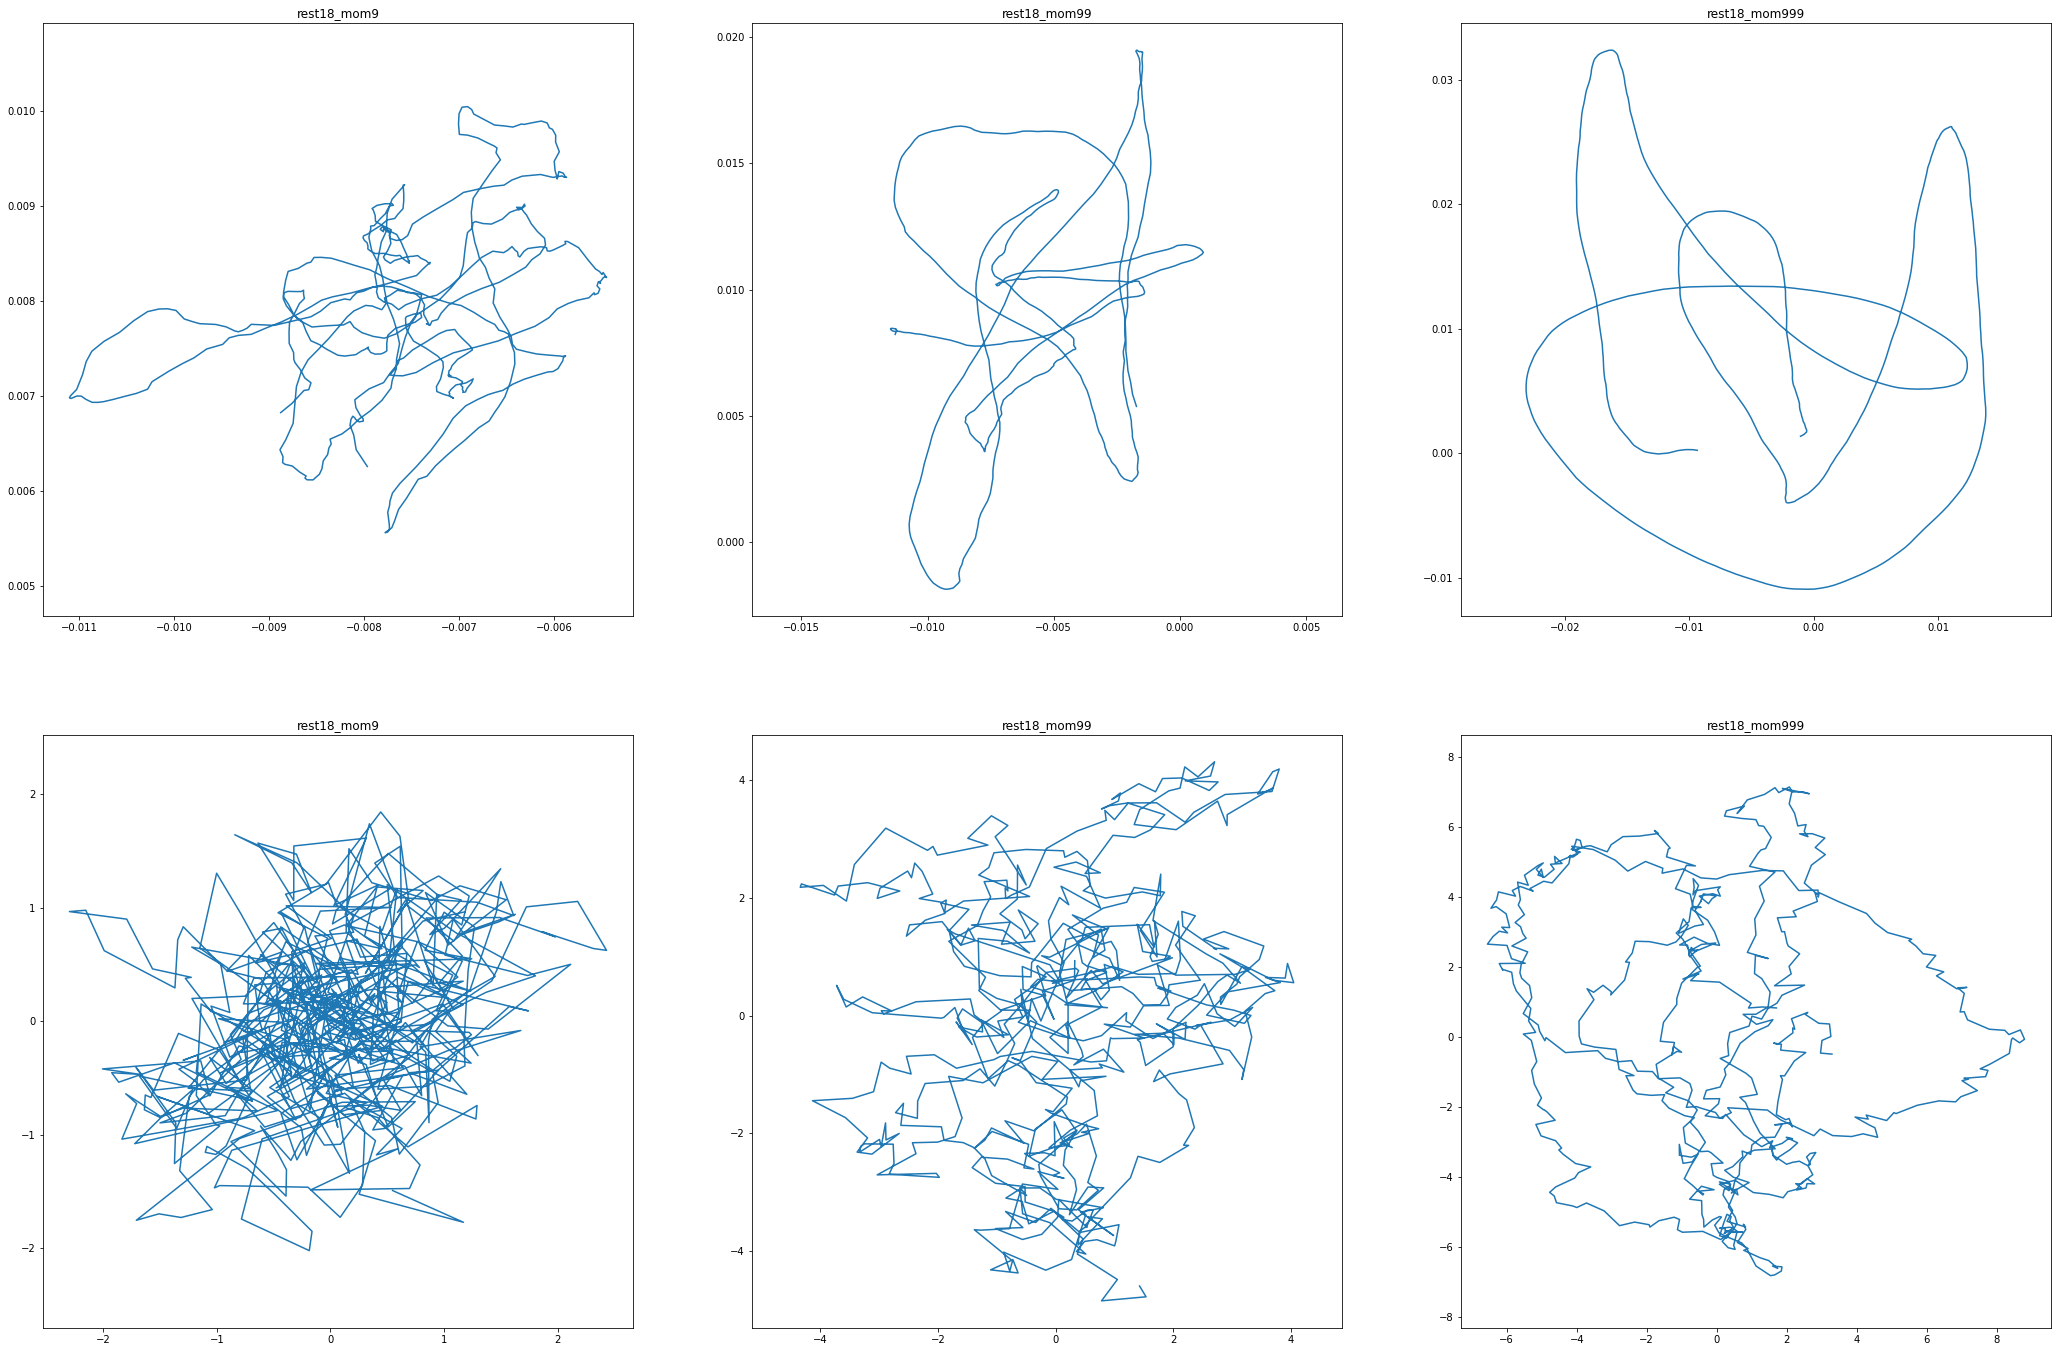

In [7]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentums = [0.9, 0.99, 0.999]
eig_idx_x = 0
eig_idx_y = 1

exp_kwargs["experiment"] = "pretrained_imagenet"

for i,momentum in enumerate(momentums):
    exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"

    projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
        exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics", suffix="_10eig_10it_40k")
    
    ax = axes[0,i]
    ax.set_title(exp_kwargs["expid"])
    ax.plot(projected_weights[3:,eig_idx_x], projected_weights[3:,eig_idx_y])
    ax.axis('equal')
    
    ax = axes[1,i]
    ax.set_title(exp_kwargs["expid"])
    ax.plot(projected_grads[3:,eig_idx_x], projected_grads[3:,eig_idx_y])
    ax.axis('equal')

In [8]:
def bounding_box(x_i, x_j):
    half_length = max(max(x_j)-min(x_j), max(x_i)-min(x_i))/2 * 1.2
    mid_j = (max(x_j)+min(x_j)) / 2
    mid_i = (max(x_i)+min(x_i)) / 2
    x_min = mid_i - half_length
    x_max = mid_i + half_length
    y_min = mid_j - half_length
    y_max = mid_j + half_length
    return x_min, x_max, y_min, y_max

def large_bounding_box_origin(x_i, x_j):
    half_length = max(max(x_j)-min(x_j), max(x_i)-min(x_i))/2 * 2
    mid_j = x_j[0]
    mid_i = x_i[0]
    x_min = mid_i - half_length
    x_max = mid_i + half_length
    y_min = mid_j - half_length
    y_max = mid_j + half_length
    return x_min, x_max, y_min, y_max

def plot_position_traj_with_heatmap(ax, x_i, x_j, lr, momentum, wd, eigenvalue_i, eigenvalue_j, 
                                    bias_i=0, bias_j=0, traj_alpha=0.5):
    #mu_i = np.mean(x_i)
    #mu_j = np.mean(x_j)
    mu_i = x_i[0] - bias_i
    mu_j = x_j[0] - bias_j
    
    x_min, x_max, y_min, y_max = large_bounding_box_origin(x_i, x_j)
    y_min += 0.0001
    y_max -= 0.0001
    
    X_i, X_j = np.meshgrid(np.linspace(x_min, x_max, 40), 
                         np.linspace(y_min, y_max, 40))
    
    scale_i = 1/(lr * (1 + momentum)) * (1 + wd / eigenvalue_i)
    scale_j = 1/(lr * (1 + momentum)) * (1 + wd / eigenvalue_j)

    Psi = scale_i*(X_i - mu_i)**2 + scale_j*(X_j - mu_j)**2

    ax.contour(X_i, X_j, Psi, colors=[plt.cm.tab10(3)], alpha=0.5, linestyles='dashed', linewidths=3)
    ax.pcolormesh(X_i, X_j, Psi, cmap='Reds')
    
    ax.plot(x_i, x_j, color="k", alpha=traj_alpha)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)

    #ax.axis('equal')
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

def plot_velocity_traj_with_heatmap(ax, x_i, x_j, eigenvalue_i, eigenvalue_j):
    x_min, x_max, y_min, y_max = bounding_box(x_i, x_j)
    
    
    #X_i, X_j = np.meshgrid(np.linspace(x_min-0.05, x_max+0.05, 40), 
    #                     np.linspace(y_min-0.1, y_max+0.1, 40))
    X_i, X_j = np.meshgrid(np.linspace(x_min, x_max, 40), 
                         np.linspace(y_min, y_max, 40))

    scale_i = 1/eigenvalue_i
    scale_j = 1/eigenvalue_j

    Psi = scale_i*(X_i)**2 + scale_j*(X_j)**2

    ax.contour(X_i, X_j, Psi, colors=[plt.cm.tab10(3)], alpha=0.5, linestyles='dashed', linewidths=3)
    ax.pcolormesh(X_i, X_j, Psi, cmap='Reds')
    
    ax.plot(x_i, x_j, color="k", alpha=0.5)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)

    #ax.axis('equal')
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    
    
def style_heatmaps(ax, ylabels=True):
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=0,
                   labelsize=24,labelrotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    if ylabels:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)   
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=False, left=True, right=False,
                   labelleft=False, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)
        ax.set_ylabel("")

    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

In [ ]:
# Do not save the output of this cell to avoid big notebook file size
nrows = 10
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

momentum= 0.9
lr = 1e-3
wd = 0
bs = 256

lr_= f"{lr:1.0e}".replace("-","n")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")

exp_kwargs["experiment"] = "linear_regression"
exp_kwargs["expid"] = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
weights, grads, eigenvectors, eigenvalues = load_cache(
            expid_eigenvalues="cifar10_hessian_evals", **exp_kwargs)
for i in range(nrows):
    for j in range(i+1, ncols):
        x_i, _ = project(weights, grads, eigenvectors, i)
        x_j, _ = project(weights, grads, eigenvectors, j)
        # Theory
        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        plot_position_traj_with_heatmap(ax, x_j, x_i, lr, momentum, wd, eigenvalues[j], eigenvalues[i])
        
        ## Empirics
        ax = axes[j,i]
        ax.set_title(exp_kwargs["expid"])
        ax.plot(x_i, x_j, color="k")

plt.savefig("position_grid_mom09_cifar.pdf")

## Another sweep of trajectories for different eigenvalues

In [ ]:
# Do not save the output of this cell to avoid big notebook file size

nrows = 10
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentum = 0.9

exp_kwargs["experiment"] = "pretrained_imagenet"
exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"
projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
            exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics", 
            suffix="_10eig_10it_40k")
for i in range(nrows):
    for j in range(i+1, ncols):
        x_i = projected_weights[3:,i]
        x_j = projected_weights[3:,j]
        # Theory
        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        plot_position_traj_with_heatmap(ax, x_j, x_i, lr, momentum, wd, eigenvalues[j], eigenvalues[i])
        
        ## Empirics
        ax = axes[j,i]
        ax.set_title(exp_kwargs["expid"])
        ax.plot(x_i, x_j, color="k")

plt.savefig("position_grid_mom09.pdf")


In [325]:
eigenvalues

array([49.83142 , 41.09971 , 33.90371 , 30.433302, 28.204748, 27.368227,
       24.296154, 24.240255, 21.81163 , 18.269054], dtype=float32)

## Velocities for the same as above

In [ ]:
# Do not save the output of this cell to avoid big notebook file size
nrows = 10
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentum = 0.9

exp_kwargs["experiment"] = "pretrained_imagenet"
exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"
projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
            exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics", 
            suffix="_10eig_10it_40k")
for i in range(nrows):
    for j in range(i+1, ncols):
        x_i = projected_grads[3:,i]
        x_j = projected_grads[3:,j]
        # Theory
        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        plot_velocity_traj_with_heatmap(ax, x_j, x_i, eigenvalues[j], eigenvalues[i])
        
        # Empirical
        ax = axes[j,i]
        ax.set_title(exp_kwargs["expid"])
        ax.plot(x_i, x_j, color="k")
        ax.axis('equal')

plt.savefig("velocity_grid_mom09.pdf")


## Testing longer trajectories on this for the final plot
### Don't forget to comment out the evaluations in the lean ckpt

python train.py --experiment pretrained_imnet_oscillations --expid res18_mom9_1epoch --save-dir gs://jv_neural_mechanics --dataset imagenet --data-dir /home/jvrsgsty/data --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 1 --save-freq 1 --train-batch-size 32 --lr 1e-04 --wd 0.0001 --momentum 0.9 --tpu jv-pt-tpu-01 --overwrite -v --pretrained True --lean-ckpt True


In [54]:
d.keys()

dict_keys(['dist_from_start', 'projected_pos', 'projected_vel'])

## Position trajectories for a wider sweep of eigenvalues

In [ ]:
# Do not save the output of this cell
nrows =5
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentum = 0.9

#eig_idxs = [0,3,7,11,14]
eig_idxs = [0,8,14,23,29]

experiment = "pretrained_imagenet"
expid = f"rest18_pretrained_initial_30evals_40k"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/metrics/spectral.h5")
eigenvalues = d["eigenvalues"]

#experiment = "pretrained_imnet_oscillations"
#expid = f"res18_mom9_1epoch"
experiment = "loss_grid"
expid = f"trajectory_5epochs"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
projected_weights = d["projected_pos"]
projected_grads = d["projected_vel"]

for i in range(nrows):
    for j in range(i+1, ncols):
        x_i = projected_weights[:,eig_idxs[i]]
        x_j = projected_weights[:,eig_idxs[j]]
        # Theory
        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        plot_position_traj_with_heatmap(ax, x_j, x_i, lr, momentum, wd, eigenvalues[eig_idxs[j]], eigenvalues[eig_idxs[i]])
        
        ## Empirics
        ax = axes[j,i]
        ax.set_title(exp_kwargs["expid"])
        ax.plot(x_i, x_j, color="k")
        ax.axis("equal")

plt.savefig("position_grid_mom09_5epoch.pdf")


In [330]:
eigenvalues

array([52.8246  , 36.923225, 33.434975, 35.244427, 30.901093, 29.616365,
       24.182629, 27.792059, 21.458214, 19.113104, 17.215656, 18.884958,
       18.083649, 15.053936, 14.28609 , 13.822349, 12.915078, 11.614013,
       12.583067, 11.647194, 10.945386, 11.458221, 11.477948, 10.933285,
       11.065723, 10.151713, 10.014554,  9.534297,  9.167529,  8.727027],
      dtype=float32)

## Velocities

In [ ]:
# Do not save cell output
nrows = 5
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentum = 0.9

#eig_idxs = [0,3,7,11,14]
eig_idxs = [0,8,14,23,29]

#experiment = "pretrained_imnet_oscillations"
#expid = f"res18_mom9_1epoch"
experiment = "loss_grid"
expid = f"trajectory_5epochs"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
projected_weights = d["projected_pos"]
projected_grads = d["projected_vel"] 
for i in range(nrows):
    for j in range(i+1, ncols):
        x_i = projected_grads[:,eig_idxs[i]]
        x_j = projected_grads[:,eig_idxs[j]]
        # Theory
        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        plot_velocity_traj_with_heatmap(ax, x_j, x_i, eigenvalues[eig_idxs[j]], eigenvalues[eig_idxs[i]])
        
        ## Empirics
        ax = axes[j,i]
        ax.set_title(exp_kwargs["expid"])
        ax.plot(x_i, x_j, color="k")
        ax.axis("equal")

plt.savefig("velocity_grid_mom09_5epoch.pdf")


--x-min -0.014 --x-max -0.002 --y-min -0.0225 --y-max 0.0075 --u-idx 0 --v-idx 29

--x-min -0.023 --x-max 0.0057 --y-min -0.0231 --y-max 0.0055 --u-idx 0 --v-idx 29

--x-min -0.0086 --x-max 0.0033 --y-min -0.0015 --y-max 0.0104

--x-min -0.015 --x-max 0.0048 --y-min -0.0068 --y-max 0.013


In [398]:
# Train scripts for the grid
filename = "train_loss_grid"
EXPS_PER_FILE = 20
num_exps = 0
tpu_idx = 1
f = open(f"{filename}_{tpu_idx}.sh","w+")
f.write("#!/bin/bash \n \n")
for x_begin in [0,10,20,30]:
    for y_begin in [0,10,20,30]: #range(40):
        command = (f"python loss_grid.py --experiment loss_grid "
                   f"--expid res18_40x40_origin --save-dir gs://jv_neural_mechanics "
                   f"--dataset imagenet --data-dir /home/jvrsgsty/data "
                   f"--model-dir /home/jvrsgsty/models --model resnet18 "
                   f"--model-class imagenet  --test-batch-size 256 --train-batch-size 256 "
                   f"--overwrite --pretrained True --spectral-path /home/jvrsgsty/spectral_it9.h5 "
                   f"--x-min -0.015 --x-max 0.0048 --y-min -0.0068 --y-max 0.013 "
                   f"--u-idx 0 --v-idx 29 --x-begin {x_begin} --x-end {x_begin+1} "
                   f"--y-begin {y_begin} --y-end {y_begin+10} --tpu jv-pt-tpu-0{tpu_idx} --workers 8")
        f.write(command)
        f.write("\n\n")
        num_exps += 1
        if num_exps >= EXPS_PER_FILE:
            tpu_idx += 1
            num_exps = 0
            f.close()
            f = open(f"{filename}_{tpu_idx}.sh","w+")
            f.write("#!/bin/bash \n \n")
f.close()

In [563]:
# Assemble grid from individual files, figure out missing
num_rows = 40
num_cols = 40
experiment = "loss_grid"
#expid = f"res18_40x40"
#expid = f"res18_40x40_single"
#expid = f"res18_40x40_square_notransform"
#expid = f"res18_40x40_square_notransform_eval"
#expid = f"res18_40x40_final"
#expid = f"res18_40x40_origin_deterministic_loader"
expid = f"res18_40x40_origin"
load_path = f"{CACHE_PATH}/{experiment}/{expid}/grid"

train_loss = np.ones((num_rows, num_cols))*1.31981858
test_loss = np.ones((num_rows, num_cols))*1.24773066
train_acc = np.ones((num_rows, num_cols))*78.968
test_acc = np.ones((num_rows, num_cols))*69.664
missing = []
for x in range(num_rows):
    for y in range(num_cols):
        try:
            d = dd.io.load(f"{load_path}/{x}_{y}.h5")
            train_loss[x,y] = d["train_loss"]
            #if train_loss[x,y] < 1.31:
                #train_loss[x,y] = 1.31691543
            test_loss[x,y] = d["test_loss"]
            train_acc[x,y] = d["train_top1"]
            test_acc[x,y] = d["test_top1"]
        except:
            missing.append((x,y))
            print("Missing entry ", x, y)
        

In [422]:
len(missing)

0

In [223]:
# Train scripts for missing entries
filename = "train_loss_grid_missing"
EXPS_PER_FILE = 8
num_exps = 0
tpu_idx = 1
f = open(f"{filename}_{tpu_idx}.sh","w+")
f.write("#!/bin/bash \n \n")
for x,y in missing:
    command = (f"python loss_grid.py --experiment loss_grid "
               f"--expid res18_40x40_origin --save-dir gs://jv_neural_mechanics "
               f"--dataset imagenet --data-dir /home/jvrsgsty/data "
               f"--model-dir /home/jvrsgsty/models --model resnet18 "
               f"--model-class imagenet  --test-batch-size 256 --train-batch-size 256 "
               f"--overwrite --pretrained True --spectral-path /home/jvrsgsty/spectral_it9.h5 "
               f"--x-min -0.015 --x-max 0.0048 --y-min -0.0068 --y-max 0.013 "
               f"--u-idx 0 --v-idx 29 --x-begin {x} --x-end {x+1} "
               f"--y-begin {y} --y-end {y+1} --tpu jv-pt-tpu-0{tpu_idx} --workers 8")
    f.write(command)
    f.write("\n\n")
    num_exps += 1
    if num_exps >= EXPS_PER_FILE:
        tpu_idx += 1
        num_exps = 0
        f.close()
        f = open(f"{filename}_{tpu_idx}.sh","w+")
        f.write("#!/bin/bash \n \n")
f.close()

In [387]:
train_loss[:, 0]

array([1.30633497, 1.32098002, 1.32066597, 1.32043889, 1.32008514,
       1.31981858, 1.3195139 , 1.31918927, 1.31900839, 1.31876686,
       1.30355244, 1.31834451, 1.31803993, 1.31785529, 1.31771186,
       1.31754386, 1.31735544, 1.31716309, 1.31703341, 1.31687211,
       1.30192864, 1.31669903, 1.31662817, 1.31655567, 1.31661119,
       1.31660302, 1.31662902, 1.31664109, 1.31667355, 1.31675492,
       1.30207907, 1.31685153, 1.31691543, 1.3170963 , 1.31717305,
       1.31731717, 1.31748296, 1.31765883, 1.31785657, 1.3182641 ])

In [ ]:
# visualize grid progress: do not save cell output
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))
axes[0,0].pcolormesh(train_loss.T, cmap="Blues")
axes[0,1].pcolormesh(test_loss.T, cmap="Blues")
axes[1,0].pcolormesh(train_acc.T, cmap="Blues")
axes[1,1].pcolormesh(test_acc.T, cmap="Blues")

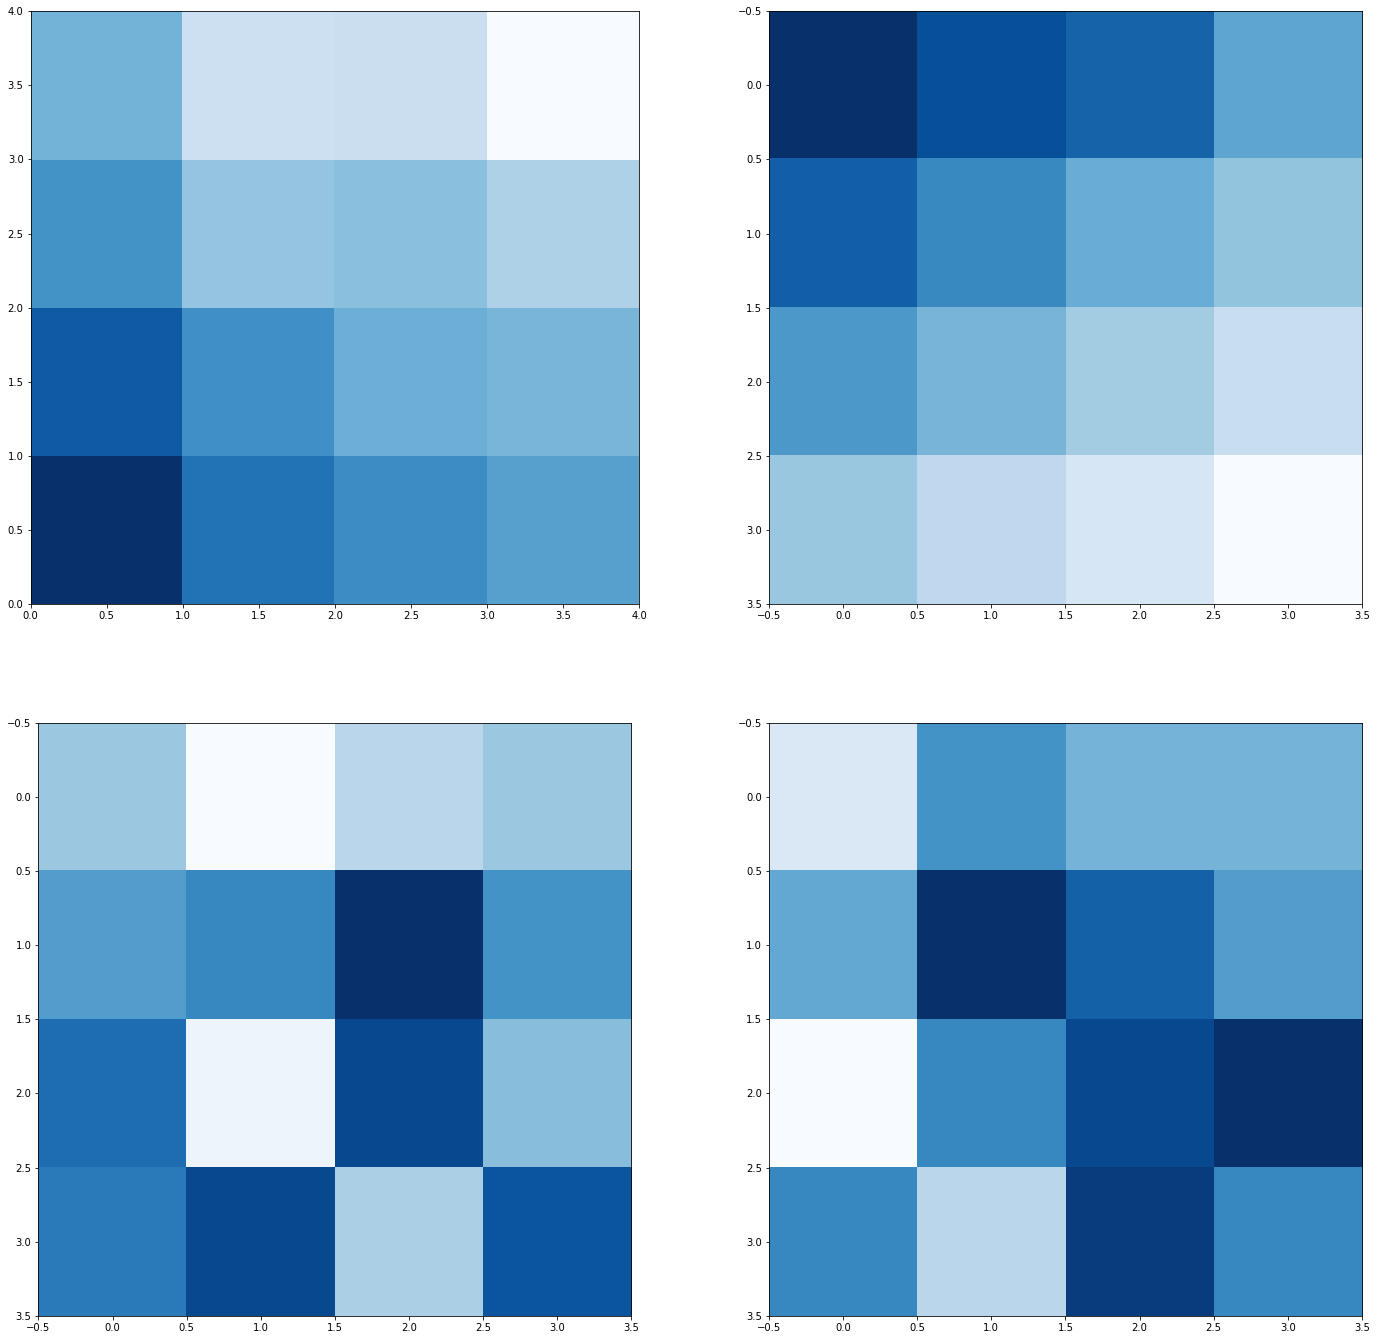

In [74]:
# Visualize grid debug
num_rows = 4
num_cols = 4
experiment = "loss_grid"
expid = "debug_xrange"
expid = "debug_xrange_notransform"
load_path = f"{CACHE_PATH}/{experiment}/{expid}/grid"

train_loss = np.ones((num_rows, num_cols))#*1.90620152
test_loss = np.ones((num_rows, num_cols))#*1.25078592
train_acc = np.ones((num_rows, num_cols))#*56.108
test_acc = np.ones((num_rows, num_cols))#*69.664
missing = []
for x in range(num_rows):
    for y in range(num_cols):
        try:
            d = dd.io.load(f"{load_path}/{x}_{y}.h5")
            train_loss[x,y] = d["train_loss"]
            test_loss[x,y] = d["test_loss"]
            train_acc[x,y] = d["train_top1"]
            test_acc[x,y] = d["test_top1"]
        except:
            missing.append((x,y))
            print("Missing entry ", x, y)
        
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows))
axes[0,0].pcolormesh(train_loss, cmap="Blues")
axes[0,1].imshow(test_loss, cmap="Blues")
axes[1,0].imshow(train_acc, cmap="Blues")
axes[1,1].imshow(test_acc, cmap="Blues")

In [255]:
def plot_position_traj_empirics(ax, x_i, x_j, Psi, traj_alpha=0.5):
    x_min, x_max, y_min, y_max = large_bounding_box_origin(x_i, x_j)

    ## Empirics
    ax.plot(x_i, x_j, color="k", alpha=traj_alpha)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)
    
    if Psi is not None:
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 40), 
                           np.linspace(y_min, y_max, 40))

        ax.contour(X, Y, Psi, colors=[plt.cm.tab10(0)], alpha=0.5, linestyles='dashed', linewidths=3)
        ax.pcolormesh(X, Y, Psi, cmap='Blues')
    #ax.axis("equal")
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

In [564]:
train_loss[0]

array([1.32148994, 1.32140625, 1.32141621, 1.32135221, 1.32132148,
       1.32129148, 1.32122402, 1.32123364, 1.32124941, 1.32116474,
       1.32121917, 1.32119032, 1.32109042, 1.32110055, 1.3210137 ,
       1.32089527, 1.32085221, 1.32085204, 1.32079551, 1.32079933,
       1.3208416 , 1.32081763, 1.32081772, 1.32082749, 1.32084501,
       1.32095361, 1.32089206, 1.32091162, 1.32088307, 1.32084856,
       1.3209939 , 1.32099716, 1.32113779, 1.32109288, 1.32116535,
       1.32119413, 1.32120249, 1.32114746, 1.32124501, 1.32131878])

In [565]:
test_loss[0]

array([1.2498647 , 1.24983718, 1.2498107 , 1.24973969, 1.2497414 ,
       1.24962693, 1.24959964, 1.24955922, 1.24950933, 1.24947753,
       1.24948164, 1.24940213, 1.24935257, 1.24931155, 1.24929159,
       1.24919526, 1.24919469, 1.24917484, 1.24909265, 1.24905843,
       1.24903762, 1.24898437, 1.24895255, 1.24899332, 1.24900844,
       1.24902032, 1.24895874, 1.2489345 , 1.24896414, 1.24893629,
       1.24890922, 1.2489185 , 1.24890795, 1.24899037, 1.24896533,
       1.24896263, 1.24897508, 1.24897827, 1.24902302, 1.24905175])

In [668]:
eigenvalues

array([52.8246  , 36.923225, 33.434975, 35.244427, 30.901093, 29.616365,
       24.182629, 27.792059, 21.458214, 19.113104, 17.215656, 18.884958,
       18.083649, 15.053936, 14.28609 , 13.822349, 12.915078, 11.614013,
       12.583067, 11.647194, 10.945386, 11.458221, 11.477948, 10.933285,
       11.065723, 10.151713, 10.014554,  9.534297,  9.167529,  8.727027],
      dtype=float32)

In [467]:
experiment = "loss_grid"
expid = f"res18_gradient_subset"
grad = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/metrics/spectral.h5", "/gradient")

In [468]:
grad.shape

torch.Size([11689512])

In [473]:
projected_grad = eigenvectors.T @ grad.cpu().numpy()

In [483]:
bias_29 = projected_grad[29]/eigenvalues[29]
bias_29

-7.9077305e-05

In [484]:
bias_0 = projected_grad[0]/eigenvalues[0]
bias_0

-0.00079527363

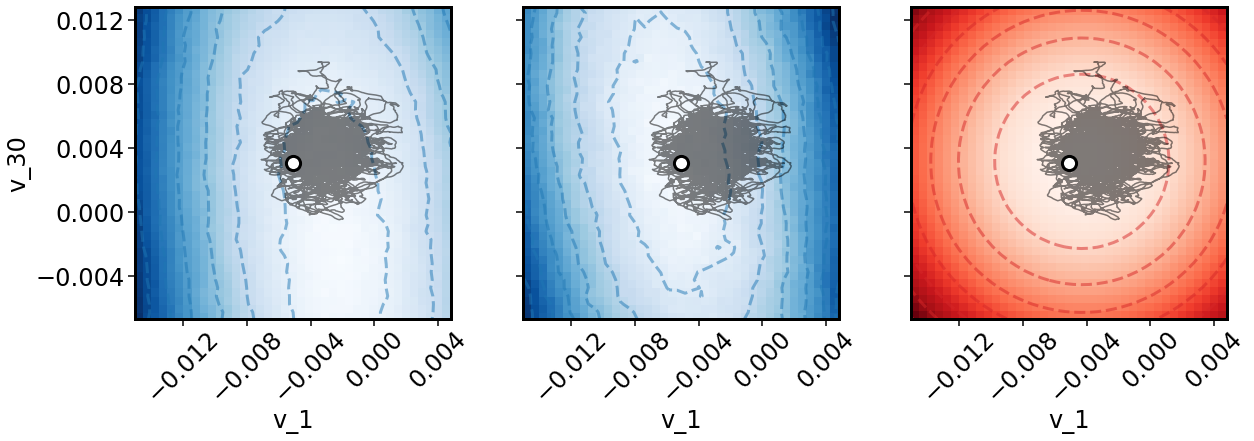

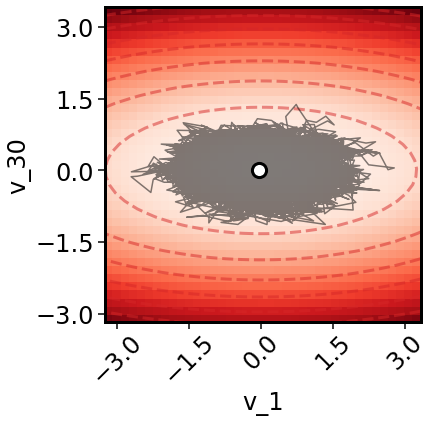

In [671]:
# visualize pos and vel
eig_idxs = [0,29]
lr = 1e-5
momentum = 0.9
wd = 1e-4

experiment = "pretrained_imagenet"
expid = f"rest18_pretrained_initial_30evals_40k"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/metrics/spectral.h5")
eigenvalues = d["eigenvalues"]
eigenvectors = d["eigenvector"]

experiment = "loss_grid"
expid = f"trajectory_5epochs"
expid = f"trajectory_5epochs_nojitter"# val performance: 69.30, _ , _ , 69.68, 69.58 , 70 
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
projected_weights = d["projected_pos"]
projected_grads = d["projected_vel"]
x_i = projected_weights[:,0]
x_j = projected_weights[:,29]

###############################
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), sharey=True)
#ax = axes[0]
#plot_position_traj_empirics(ax, x_i, x_j, None,traj_alpha=0.8)
#ax.set_xlabel("v_1", size=24)
#ax.set_ylabel("v_30", size=24)
#style_heatmaps(ax, ylabels=True)
##plt.tight_layout()
##plt.savefig("position.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[0]
plot_position_traj_empirics(ax, x_i, x_j, train_loss.T, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=True)
#plt.tight_layout()
#plt.savefig("position_train.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[1]
plot_position_traj_empirics(ax, x_i, x_j, test_loss.T, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=False)
#plt.tight_layout()
#plt.savefig("position_test.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[2]
plot_position_traj_with_heatmap(ax, x_i, x_j, lr, momentum, wd, eigenvalues[0], eigenvalues[29], 
                                bias_0, bias_29, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=False)
plt.tight_layout()
#plt.savefig("position_theory.pdf")
plt.savefig("position_row.pdf")

nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
x_i = projected_grads[:,0]
x_j = projected_grads[:,29]
plot_velocity_traj_with_heatmap(axes, x_i, x_j, eigenvalues[0], eigenvalues[29])
style_heatmaps(axes)
axes.set_xlabel("v_1", size=24)
axes.set_ylabel("v_30", size=24)
plt.tight_layout()
plt.savefig("velocity_theory.png")